In [310]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

## Create dataset for regression

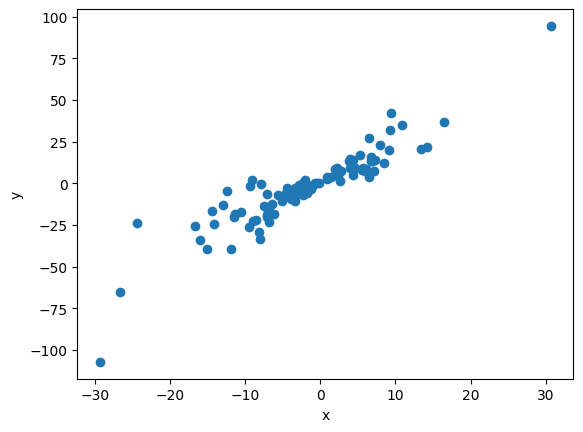

In [311]:
x = torch.randn(100, 1) * 10
y = 2*x + 1 + x * torch.randn(100, 1)

plt.plot(x.numpy(), y.numpy(), 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Applying Thresholds and Sigmoid Functions

In [312]:
class CompressedModel(nn.Module):
    def __init__(self, a_init, a_index, tau=1):
        super().__init__()
        self.a = nn.Parameter(a_init)
        self.a_index = a_index
        self.tau = tau
    
    def forward(self, x, eval = False):
        ## x shape [B, n]
        y = nn.Sigmoid()((x[:,self.a_index]-self.a) / self.tau)
        if eval:
            y = torch.round(y)
        return y

In [313]:
a_init = torch.tensor([-15.,-5.,5.,15.], requires_grad=True)
a_index = torch.tensor([0,0,0,0])

model = CompressedModel(a_init, a_index)
output = model(x.view(-1,1))

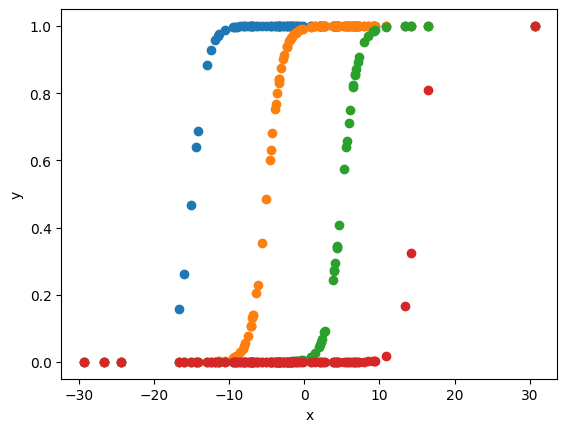

In [314]:
plt.figure()

for f in range(4):
    plt.plot(x.numpy(), output[:,f].detach().numpy(), 'o')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

If we divide $\tau$ by 10, then the functions will be much sharper:

In [315]:
model.tau = model.tau / 10
output = model(x.view(-1,1))

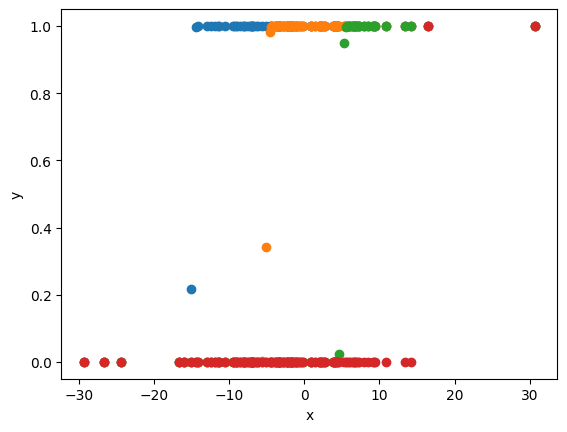

In [316]:
plt.figure()

for f in range(4):
    plt.plot(x.numpy(), output[:,f].detach().numpy(), 'o')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Create basic model + MLP

Ideas:
- linear layers before compression layer
- computer vision application? --> per pixel compression?
- test Classification task 
- keep interpretability vs. more complex functions at beginning? 

To dos:
- hyperparameter tuning: number of a's (Karsten)
- automatic detection: how much thresholds per feature? grid search too expensive? 
- develop layer with n inputs and m outputs, where each output equals (nearly?) an input. --> For 2 features: convex combination per output (using sigmoid) with increasing sharpness of sigmoid. For > 2 features: Choose m pairs of features and let them fight. --> Choosing: Try random and try more elaborated methods (dependend on variance or something like this)
- literature review (Jan & Karsten)


In [317]:
class CombinedModel(nn.Module):
    def __init__(self, compressed_model, linear_model):
        super().__init__()
        self.compressed_model = compressed_model
        self.linear_model = linear_model
    
    def forward(self, x, eval = False):
        ## x shape [B, n]
        y = self.compressed_model(x)
        if eval:
            y = torch.round(y)
        z = self.linear_model(y)
        return y, z

In [318]:
class MLP_small(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_features: int, num_layers: int, activation = nn.ReLU) -> None:
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            activation(),
            *[nn.Sequential(
                nn.Linear(hidden_features, hidden_features),
                activation(),
            ) for _ in range(num_layers - 2)],
            nn.Linear(hidden_features, out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)    

In [319]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = 4,
                        out_features = 1,
                        hidden_features = 10,
                        num_layers = 2)

In [320]:
combined_model = CombinedModel(compressed_model, linear_model)
hidden_state, output = combined_model(x.view(-1,1))

In [321]:
print(output.shape)

torch.Size([100, 1])


## Train combined model

When training the combined model, we see that its prediction benefit from the smoothness of Sigmoid. But we want to have an approximation of a step function. Therefore, it is useful to decrease $\tau$ during training. 

In [322]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    hidden_state, output = combined_model(x.view(-1,1))
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

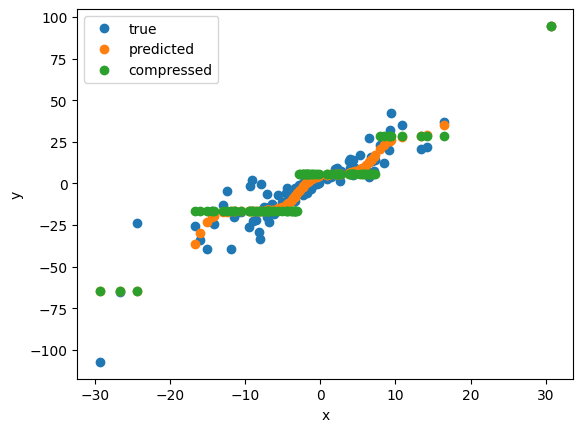

In [323]:
hidden_state, output = combined_model(x.view(-1,1))
hidden_state_compressed, output_compressed = combined_model(x.view(-1,1), eval=True)

plt.figure()
plt.plot(x.numpy(), y.numpy(), 'o', label='true')
plt.plot(x.numpy(), output.detach().numpy(), 'o', label='predicted')
plt.plot(x.numpy(), output_compressed.detach().numpy(), 'o', label='compressed')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Load California Housing

In [325]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for regression
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Test on California Housing Dataset

We test the following models on California Housing:
Comparison model with number of neurons per layer: (8,64,64,1)
Combined model with number of neurons per layer: (8,64,64,1) --> Here, the ouput of the first layer is calculated using the learnable thresholds and the sigmoid function. Note that we use 8 thresholds per feature.

In [331]:
def initialize_a(num_features, num_thresholds_per_feature, X):
    """Initializes a_init and a_index for the CompressedModel. Each feature will have num_thresholds_per_feature thresholds. 
    They are initialized as quantiles of the data.

    Args:
        num_features (int): _description_
        num_thresholds (int): _description_
        X (tensor): _description_

    Returns:
        a_init: initial threshold values, shape [num_features * num_thresholds_per_feature]
        a_index: a_index[f] is the index of the feature that threshold f belongs to, shape [num_features * num_thresholds_per_feature]
    """
    quantiles_tensor = torch.tensor([(f+1)*1/(num_thresholds_per_feature+1) for f in range(num_thresholds_per_feature)])
    a_init = torch.quantile(X, quantiles_tensor, dim = 0).T.flatten()
    a_index = torch.repeat_interleave(torch.arange(num_features), num_thresholds_per_feature)
    return a_init, a_index

In [332]:
def eval_val(model, val_dataloader, eval= False, device = 'cuda'):
    """Evaluate performance of the model on the validation set.

    Args:
        model: model to use 
        val_dataloader: dataloader of validation set
        eval (bool, optional): If True, all outputs of sigmoids will be rounded (i.e. compressed). Defaults to False.
        device (str, optional): device. Defaults to 'cuda'.

    Returns:
        _type_: _description_
    """
    with torch.no_grad():
        model.eval()
        losses = []
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            if eval:
                hidden_state, output = model(x, eval=True)    
            else:    
                output = model(x) 
                if isinstance(output, tuple):
                    output = output[1]
            loss = criterion(output, y)
            losses.append(loss.item())
        return np.mean(losses)

In [333]:
def train_comparison(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device = 'cuda', print_result = True):
    """Trains a comparison model. 

    Args:
        model: model
        train_dataloader: dataloader of training set
        val_dataloader: dataloader of validation set	
        optimizer: optimizer to use
        criterion: loss criterion
        num_epochs: number of epochs to train
        device (str, optional): device. Defaults to 'cuda'.
        print_result (bool, optional): If true, method prints intermediate results. Defaults to True.

    Returns:
        val_loss: validation loss
    """
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        val_loss = eval_val(model, val_dataloader, device = device)
        if epoch % (num_epochs//10) == 0 and print_result:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss        

In [334]:
def train_combined(combined_model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device = 'cuda', print_result=True):
    """_summary_

    Args:
        model: important: model.forward() must return hidden_state, output
        train_dataloader: dataloader of training set
        val_dataloader: dataloader of validation set	
        optimizer: optimizer to use
        criterion: loss criterion
        num_epochs: number of epochs to train
        device (str, optional): device. Defaults to 'cuda'.
        print_result (bool, optional): If true, method prints intermediate results. Defaults to True.

    Returns:
        val_loss: validation loss
    """
    factor = 0.001 ** (1/num_epochs)
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            hidden_state, output = combined_model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        combined_model.compressed_model.tau = max(combined_model.compressed_model.tau * factor, 0.001)    
        val_loss = eval_val(combined_model, val_dataloader, device = device)
        if epoch % (num_epochs//10) == 0 and print_result:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss     

In [335]:
device = 'cpu'

In [336]:
linear_comparison_model = MLP_small(in_features = 8,
                                    out_features = 1,
                                    hidden_features = 64,
                                    num_layers = 3)
linear_comparison_model.to(device);

In [337]:
a_init, a_index = initialize_a(8, 8, X_train_tensor)

In [338]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model = CombinedModel(compressed_model, linear_model)
combined_model.to(device);

In [340]:
## Train comparison model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_comparison_model.parameters(), lr=0.003)
n_epochs = 20
train_comparison(linear_comparison_model, train_loader, test_loader, optimizer, criterion, n_epochs, device=device)

Epoch 1/20, Loss: 0.9422473961761756, Val Loss: 0.42518941255716175
Epoch 3/20, Loss: 0.3638320534612781, Val Loss: 0.35563358733287226
Epoch 5/20, Loss: 0.33458487625963, Val Loss: 0.32587714332800644
Epoch 7/20, Loss: 0.3177841524052065, Val Loss: 0.31916928245471077
Epoch 9/20, Loss: 0.30412452569765636, Val Loss: 0.3079299835058359
Epoch 11/20, Loss: 0.3028492574659429, Val Loss: 0.3205104573414876
Epoch 13/20, Loss: 0.29730284612539204, Val Loss: 0.2946053124391116
Epoch 15/20, Loss: 0.28622128179138023, Val Loss: 0.3040330910911927
Epoch 17/20, Loss: 0.2857614071216694, Val Loss: 0.30212811483786656
Epoch 19/20, Loss: 0.2820484019642652, Val Loss: 0.3162900863931729


0.30021406343350043

In [342]:
## Train combined model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
n_epochs = 20
train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, device =device)

Epoch 1/20, Loss: 0.8207752672276756, Val Loss: 0.6141727727193099
Epoch 3/20, Loss: 0.4751439043717791, Val Loss: 0.4668960140301631
Epoch 5/20, Loss: 0.3937202995253164, Val Loss: 0.5475238093963036
Epoch 7/20, Loss: 0.34709220882072006, Val Loss: 0.45496360934697666
Epoch 9/20, Loss: 0.3028592171017514, Val Loss: 0.34360925738628095
Epoch 11/20, Loss: 0.28563741773597956, Val Loss: 0.3133620755030559
Epoch 13/20, Loss: 0.2760106336700824, Val Loss: 0.29675926405649916
Epoch 15/20, Loss: 0.2708064769358598, Val Loss: 0.2875222077736488
Epoch 17/20, Loss: 0.27503831730794537, Val Loss: 0.28757983698294715
Epoch 19/20, Loss: 0.2854827514221502, Val Loss: 0.28735367495280045


0.30895578265190127

In [344]:
eval_val(linear_comparison_model, test_loader,device=device), eval_val(combined_model, test_loader,device=device), eval_val(combined_model, test_loader, eval=True,device=device)

(0.30021406343350043, 0.30895578265190127, 0.31140205585039576)

In [348]:
def eval_compression(model, val_dataloader, device = 'cuda'):
    """Calculates, how far the model is from giving compressed hidden states.

    Args:
        model: important: model.forward() must return hidden_state, output
        val_dataloader: dataloader of validation set
        device (str, optional): device. Defaults to 'cuda'.

    Returns:
        : mean of the absolute difference between hidden state and rounded (i.e. compressed) hidden state
    """
    with torch.no_grad():
        model.eval()
        losses = []
        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            hidden_state, output = model(x)   
            hidden_state_compressed = torch.round(hidden_state) 
            loss = torch.mean(torch.abs(hidden_state - hidden_state_compressed))
            losses.append(loss.item())
        return np.mean(losses)

In [349]:
eval_compression(combined_model, test_loader,device=device)

0.0012575185208473928

## Evaluate multiple trainings

Let us evaluate multiple trainings for Comparison Model and Combined Model, so that we can see, which one is better in average.

In [351]:
val_losses_comparison = []
for f in tqdm(range(20)):
    linear_comparison_model = MLP_small(in_features = 8,
                                    out_features = 1,
                                    hidden_features = 64,
                                    num_layers = 3)
    linear_comparison_model.to(device);
    n_epochs=40
    optimizer = torch.optim.Adam(linear_comparison_model.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    val_loss_current = train_comparison(linear_comparison_model, train_loader, test_loader, optimizer, criterion, n_epochs, print_result=False, device = device)
    val_losses_comparison.append(val_loss_current)
    

100%|██████████| 20/20 [05:02<00:00, 15.13s/it]


In [ ]:
val_losses_combined = []
val_losses_compressed = []
for f in tqdm(range(20)):
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = 64,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model = CombinedModel(compressed_model, linear_model)
    combined_model.to(device);
    n_epochs=40
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    val_loss_current = train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, print_result=False, device =device)
    val_losses_combined.append(val_loss_current)
    val_loss_current = eval_val(combined_model, test_loader, eval = True, device = device)
    val_losses_compressed.append(val_loss_current)
    

  5%|▌         | 1/20 [00:15<04:46, 15.08s/it]

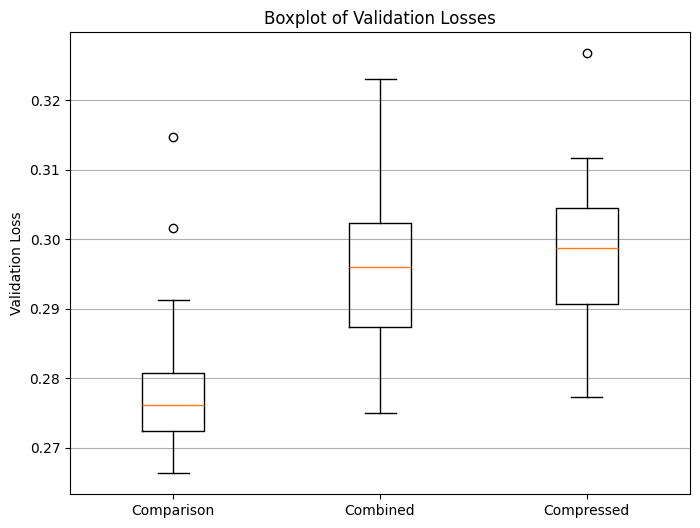

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([val_losses_comparison, val_losses_combined, val_losses_compressed], labels=['Comparison', 'Combined', 'Compressed'])
plt.ylabel('Validation Loss')
plt.title('Boxplot of Validation Losses')
plt.grid(axis='y')
plt.show()

The combined model performs not as good as the comparison model, but it is also not that far away.

## How much threshold should be used?

Lets evaluate, how the amount of thresholds influence the results.

In [30]:
min_thresholds = 1
max_thresholds = 15
num_features = 8
n_epochs = 20
n_runs_per_threshold = 10
val_losses = np.zeros((max_thresholds-min_thresholds+1, n_runs_per_threshold))
val_losses_compressed = np.zeros((max_thresholds-min_thresholds+1, n_runs_per_threshold))
device = 'cpu'

for num_thresholds in tqdm(range(min_thresholds,max_thresholds+1)):
    a_init, a_index = initialize_a(num_features, num_thresholds, X_train_tensor)
    for run in range(n_runs_per_threshold):
        compressed_model = CompressedModel(a_init, a_index)
        linear_model = MLP_small(in_features = num_thresholds*num_features,
                                out_features = 1,
                                hidden_features = 64,
                                num_layers = 2)
        combined_model = CombinedModel(compressed_model, linear_model)
        combined_model.to(device);
        optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
        criterion = nn.MSELoss()
        val_loss_current = train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, print_result=False, device= device)
        val_losses[num_thresholds-min_thresholds, run] = val_loss_current
        val_loss_current = eval_val(combined_model, test_loader, eval = True, device = device)
        val_losses_compressed[num_thresholds-min_thresholds, run] = val_loss_current


100%|██████████| 15/15 [18:20<00:00, 73.35s/it]


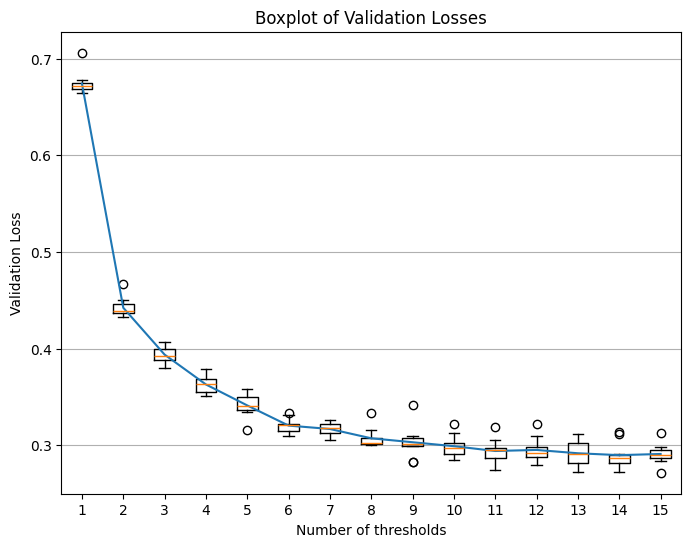

In [34]:
plt.figure(figsize=(8, 6))
plt.boxplot(val_losses.T, tick_labels=range(min_thresholds, max_thresholds + 1))
plt.plot(range(min_thresholds, max_thresholds+1), np.mean(val_losses, axis=1))    
plt.xlabel('Number of thresholds')
plt.ylabel('Validation Loss')
plt.title('Boxplot of Validation Losses')
plt.grid(axis='y')
plt.show()

## Plot models decision boundaries

Text(0.5, 1.0, 'Initial Decision Steps')

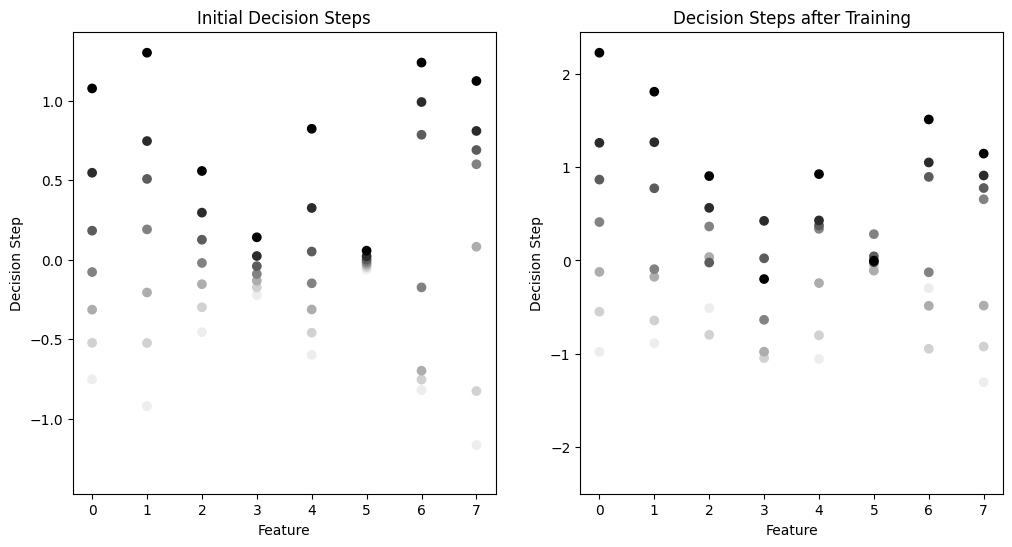

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,2)
for f in range(8):
    plt.scatter(f*np.ones(8), combined_model.compressed_model.a[f*8:(f+1)*8].detach().cpu().numpy(), c = np.arange(8), cmap= 'Greys')
plt.xticks(np.arange(8), np.arange(8)) 
plt.xlabel('Feature')
plt.ylabel('Decision Step')
plt.title('Decision Steps after Training')

plt.subplot(1,2,1)
for f in range(8):
    plt.scatter(f*np.ones(8), a_init[f*8:(f+1)*8],  c = np.arange(8), cmap= 'Greys')
plt.xticks(np.arange(8), np.arange(8)) 
plt.xlabel('Feature')
plt.ylabel('Decision Step')
plt.title('Initial Decision Steps')

## Comparison Trees

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse_rf}")


Random Forest MSE: 0.47345772327303354


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=256, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse_rf}")

Random Forest MSE: 0.6027969396916061


In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Train a Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_model.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree}")

Decision Tree MSE: 0.4972838079675652


## Test Linear Regression Model

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")

Linear Regression MSE: 0.5558915986952442


In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the linear regression model
poly_linear_model = LinearRegression()
poly_linear_model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_poly = poly_linear_model.predict(X_test_poly)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print(f"Polynomial Linear Regression MSE: {mse_poly}")

Polynomial Linear Regression MSE: 0.46430152383011586


In [50]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate polynomial features of degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the Lasso Linear Regression model
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_lasso = lasso_model.predict(X_test_poly)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso Linear Regression MSE: {mse_lasso}")

Lasso Linear Regression MSE: 0.6135867129893572


## Automatic Feature Selection

We want to decide automatically, which feature to use how often, i.e. which feature should get how much thresholds.

In [ ]:
class FeatureSelectionLayer(nn.Module):
    """A layer that selects one of two features per output value based on a sigmoid function."""
    def __init__(self, first_index, second_index, tau=1.) -> None:
        """Initializes the layer.

        Args:
            first_index (tensor): First index of comparison, shape [out_features]
            second_index (s): Second index of comparison, shape [out_features]
            tau (float, optional): Sharpening factor. Defaults to 1.
        """
        super().__init__()
        self.first_index = first_index
        self.second_index = second_index
        out_features = len(second_index)
        self.sigmoid_factor = nn.Parameter(torch.zeros(out_features))
        self.sigmoid = nn.Sigmoid()
        self.tau = tau

    def forward(self, x: torch.Tensor, eval = False) -> torch.Tensor:
        """Using the sigmoid_factor, we calculate how much of the first feature should be used per output value.  

        Args:
            x (torch.Tensor): input tensor, shape [B, num_features]
            eval (bool, optional): If True, sigmoid_factor is rounded (i.e. compressed). Defaults to False.

        Returns:
            torch.Tensor: Selected feature, shape [B, out_features]
        """
        self.factor = self.sigmoid(self.sigmoid_factor / self.tau)
        if eval:
            self.factor = torch.round(self.factor)
        return x[:,self.first_index] * self.factor  + x[:,self.second_index] * (1-self.factor) 
    
    def get_features(self):
        """Returns the index of the selected feature for each output value."""
        feature_index = torch.where(self.sigmoid_factor.to('cpu') >= 0, self.first_index, self.second_index)
        return feature_index


In [ ]:
class CombinedModelNew(nn.Module):
    """New Class of combined model, containing a feature selection layer, a compressed model and a linear model."""
    def __init__(self, feature_selection_layer, compressed_model, linear_model) -> None:
        super().__init__()
        self.feature_selection_layer = feature_selection_layer
        self.compressed_model = compressed_model
        self.linear_model = linear_model

    def forward(self, x: torch.Tensor, eval = False) -> torch.Tensor:
        feature_selected = self.feature_selection_layer(x, eval = eval)
        hidden_state = self.compressed_model(feature_selected, eval = eval)
        y = self.linear_model(hidden_state)
        return hidden_state, y

In [ ]:
def train_combined_model_new(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, device = 'cuda', print_result=True):
    """Trains a combined model. Difference to train_combined_model: tau is set for feature selection layer and compressed model.

    Args:
        model: important: model.forward() must return hidden_state, output
        train_dataloader: dataloader of training set
        val_dataloader: dataloader of validation set	
        optimizer: optimizer to use
        criterion: loss criterion
        num_epochs: number of epochs to train
        device (str, optional): device. Defaults to 'cuda'.
        print_result (bool, optional): If true, method prints intermediate results. Defaults to True.

    Returns:
        val_loss: validation loss
    """
    factor = 0.001 ** (1/num_epochs)
    for epoch in range(num_epochs):
        model.train()
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            hidden_state, output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        model.feature_selection_layer.tau = max(model.feature_selection_layer.tau * factor, 0.001)  
        model.compressed_model.tau = max(model.compressed_model.tau * factor, 0.001)  
        val_loss = eval_val(model, val_dataloader, device = device)
        if epoch % (num_epochs//10) == 0 and print_result:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}, Val Loss: {val_loss}')
    return val_loss


In [126]:
device = 'cpu'
num_thresholds = 64
num_features = 8
first_index = torch.repeat_interleave(torch.arange(num_features), num_thresholds // num_features)
second_index = torch.cat([torch.arange(num_thresholds//num_features) for _ in range(num_features)])
a_init = torch.randn(num_thresholds)
a_index = torch.arange(num_thresholds)

feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = num_thresholds,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)

combined_model_new.to(device);

In [127]:
feature_index_before = feature_selection_layer.get_features()

In [129]:
optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
criterion = nn.MSELoss()
n_epochs = 25
train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device)

Epoch 1/25, Loss: 0.8570191156725551, Val Loss: 0.6610307381703303
Epoch 3/25, Loss: 0.4757405345061029, Val Loss: 0.6307152619728675
Epoch 5/25, Loss: 0.4029388475672219, Val Loss: 0.6537017015310435
Epoch 7/25, Loss: 0.35042954692544864, Val Loss: 0.37368708573854886
Epoch 9/25, Loss: 0.3149165598343509, Val Loss: 0.4145399861610853
Epoch 11/25, Loss: 0.30449044011359994, Val Loss: 0.34489996891755326
Epoch 13/25, Loss: 0.2996857146364312, Val Loss: 0.3323380016363584
Epoch 15/25, Loss: 0.306452243422815, Val Loss: 0.3373555660247803
Epoch 17/25, Loss: 0.3051699461169945, Val Loss: 0.31565870848985816
Epoch 19/25, Loss: 0.29896523442494777, Val Loss: 0.3239848487652265
Epoch 21/25, Loss: 0.29611806161412896, Val Loss: 0.306457528930444
Epoch 23/25, Loss: 0.29588273375533347, Val Loss: 0.33726956569231475
Epoch 25/25, Loss: 0.31073992826448854, Val Loss: 0.328917205448334


0.328917205448334

In [130]:
eval_val(combined_model_new, test_loader, device = device), eval_val(combined_model_new, test_loader, eval=True, device = device)

(0.328917205448334, 0.3320779094329247)

In [131]:
feature_index_after = combined_model_new.feature_selection_layer.get_features()
feature_index_after

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 1, 5, 6, 1, 0, 2, 2, 2, 2, 5, 6, 7,
        0, 3, 3, 3, 3, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 5, 3, 5, 5, 5, 5,
        0, 1, 6, 6, 6, 5, 6, 7, 0, 7, 2, 7, 7, 7, 7, 7])

In [ ]:
feature_idx, feature_count = torch.unique(feature_index_after, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7]), tensor([15,  6,  6,  7,  1, 11,  8, 10]))

In [133]:
torch.unique(feature_index_before, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7]), tensor([8, 8, 8, 8, 8, 8, 8, 8]))

In [143]:
runs = 10
device = 'cpu'
feature_count_total = torch.zeros(runs,num_features)
for f in tqdm(range(runs)):
    n_epochs = 25
    a_init = torch.randn(num_thresholds)
    a_index = torch.arange(num_thresholds)

    feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)
    optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    feature_index_after = combined_model_new.feature_selection_layer.get_features()
    feature_idx, feature_count = torch.unique(feature_index_after, return_counts=True)
    sort_idx = torch.argsort(feature_idx)
    feature_count = feature_count[sort_idx]
    feature_count_total[f] = feature_count

100%|██████████| 10/10 [01:51<00:00, 11.17s/it]


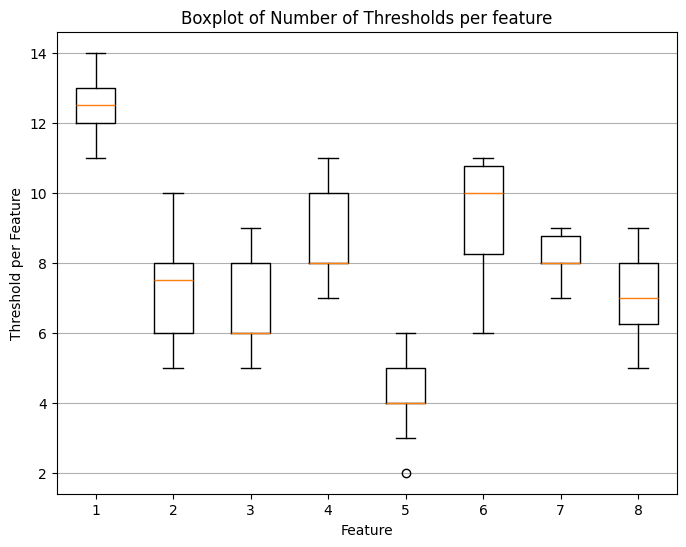

In [144]:
plt.figure(figsize=(8, 6))
plt.boxplot(feature_count_total)
plt.xlabel('Feature')
plt.ylabel('Threshold per Feature')
plt.title('Boxplot of Number of Thresholds per feature')
plt.grid(axis='y')
plt.show()

In [174]:
a_index = torch.repeat_interleave(torch.arange(num_features),feature_count)
quantile_tensor = torch.cat([torch.tensor([(f+1)/(count+1) for f in range(count)]) for count in feature_count])
a_init = torch.stack([torch.quantile(X_train_tensor[:,a_index[f]], quantile_tensor[f]) for f in range(num_thresholds)])

In [182]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model = CombinedModel(compressed_model, linear_model)
combined_model.to(device);

In [189]:
## Train combined model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
n_epochs = 20
train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, device = device)

Epoch 1/20, Loss: 0.8181240281393362, Val Loss: 0.6051349089695857
Epoch 3/20, Loss: 0.474003836166027, Val Loss: 0.5495985141167274
Epoch 5/20, Loss: 0.3902636955874835, Val Loss: 0.641951322555542
Epoch 7/20, Loss: 0.32979548705178635, Val Loss: 0.44641410754277155
Epoch 9/20, Loss: 0.3050534061567728, Val Loss: 0.3761028856039047
Epoch 11/20, Loss: 0.292986071040464, Val Loss: 0.2939794957637787
Epoch 13/20, Loss: 0.27821763157266977, Val Loss: 0.30851639096553507
Epoch 15/20, Loss: 0.2773818641958773, Val Loss: 0.28536673486232755
Epoch 17/20, Loss: 0.2793928731030734, Val Loss: 0.2958116495838532
Epoch 19/20, Loss: 0.28569336249962335, Val Loss: 0.2921016165843377


0.30270549001602026

## Test with random comparisons

In [ ]:
def create_indices(num_features, num_thresholds):
    first_index = torch.repeat_interleave(torch.arange(num_features-1), torch.arange(num_features-1, 0,-1))
    second_index = torch.cat([torch.arange(f+1,num_features) for f in range(num_features)])
    if num_thresholds <= len(first_index):
        selected_index = torch.randperm(len(first_index))[:num_thresholds]
    else:
        amount_of_comparisons = num_thresholds // len(first_index)
        rest_comparisons = num_thresholds % len(first_index)
        selected_index = torch.cat([torch.randperm(len(first_index)) for _ in range(amount_of_comparisons)])
        selected_index = torch.cat([selected_index, torch.randperm(len(first_index))[:rest_comparisons]])    

    first_index_selected = first_index[selected_index]
    second_index_selected = second_index[selected_index]
    counter = 0
    while not torch.sort(torch.unique(torch.cat([first_index_selected, second_index_selected])))[0].shape[0] == num_features and counter <= 10:
        selected_index = torch.randperm(len(first_index))[:num_thresholds]
        first_index_selected = first_index[selected_index]
        second_index_selected = second_index[selected_index]
        counter += 1
    if counter > 10:
        print('No valid indices found')
        return None, None
    return first_index_selected, second_index_selected


first_index, second_index = create_indices(8, 6)

In [214]:
runs = 10
device = 'cpu'
feature_count_total = torch.zeros(runs,num_features)
num_thresholds = 64
num_features = 8
for f in tqdm(range(runs)):
    n_epochs = 25
    a_init = torch.randn(num_thresholds)
    a_index = torch.arange(num_thresholds)
    first_index, second_index = create_indices(num_features, num_thresholds)
    feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)
    optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    feature_index_after = combined_model_new.feature_selection_layer.get_features()
    feature_idx, feature_count = torch.unique(feature_index_after, return_counts=True)
    sort_idx = torch.argsort(feature_idx)
    feature_count = feature_count[sort_idx]
    feature_count_total[f] = feature_count

100%|██████████| 10/10 [01:57<00:00, 11.70s/it]


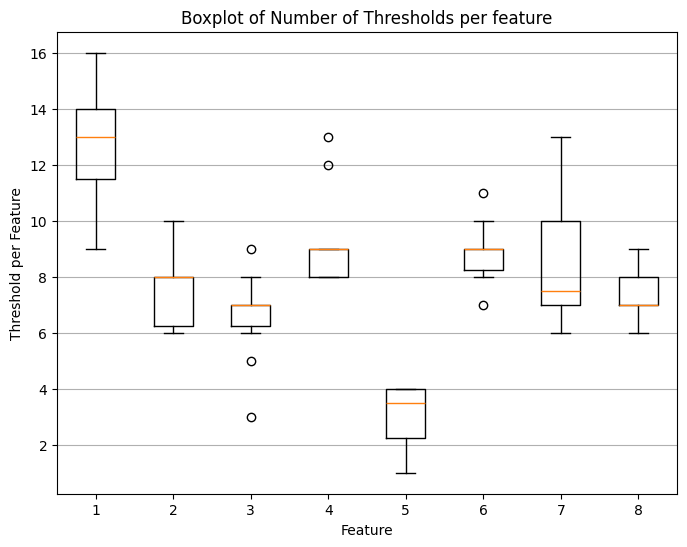

In [216]:
plt.figure(figsize=(8, 6))
plt.boxplot(feature_count_total)
plt.xlabel('Feature')
plt.ylabel('Threshold per Feature')
plt.title('Boxplot of Number of Thresholds per feature')
plt.grid(axis='y')
plt.show()

In [231]:
device = 'cpu'
feature_count_total = torch.empty(0,num_features)
max_number_thresholds = 64
step = 4
num_features = 8
val_losses = []
val_loss_compressed = []
for num_thresholds in tqdm(range(8,max_number_thresholds+1,step)):
    n_epochs = 25
    a_init = torch.randn(num_thresholds)
    a_index = torch.arange(num_thresholds)
    first_index, second_index = create_indices(num_features, num_thresholds)
    feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)
    optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
    criterion = nn.MSELoss()
    train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    val_loss_current = eval_val(combined_model_new, test_loader, device = device)
    val_losses.append(val_loss_current)
    val_loss_current = eval_val(combined_model_new, test_loader, eval=True, device = device)
    val_loss_compressed.append(val_loss_current)
    feature_index_after = combined_model_new.feature_selection_layer.get_features()
    feature_count = torch.zeros(num_features)
    for f in range(num_features):
        feature_count[f] = torch.sum(feature_index_after == f) / num_thresholds
    feature_count_total = torch.cat([feature_count_total, feature_count.unsqueeze(0)], dim = 0)

  0%|          | 0/15 [00:00<?, ?it/s]

8


  7%|▋         | 1/15 [00:10<02:28, 10.58s/it]

12


 13%|█▎        | 2/15 [00:21<02:20, 10.82s/it]

16


 20%|██        | 3/15 [00:32<02:09, 10.76s/it]

20


 27%|██▋       | 4/15 [00:43<01:58, 10.78s/it]

24


 33%|███▎      | 5/15 [00:53<01:46, 10.63s/it]

28


 40%|████      | 6/15 [01:03<01:34, 10.52s/it]

32


 47%|████▋     | 7/15 [01:14<01:23, 10.48s/it]

36


 53%|█████▎    | 8/15 [01:24<01:13, 10.54s/it]

40


 60%|██████    | 9/15 [01:35<01:03, 10.63s/it]

44


 67%|██████▋   | 10/15 [01:46<00:53, 10.76s/it]

48


 73%|███████▎  | 11/15 [01:57<00:43, 10.89s/it]

52


 80%|████████  | 12/15 [02:08<00:32, 10.95s/it]

56


 87%|████████▋ | 13/15 [02:20<00:22, 11.13s/it]

60


 93%|█████████▎| 14/15 [02:31<00:11, 11.08s/it]

64


100%|██████████| 15/15 [02:42<00:00, 10.85s/it]


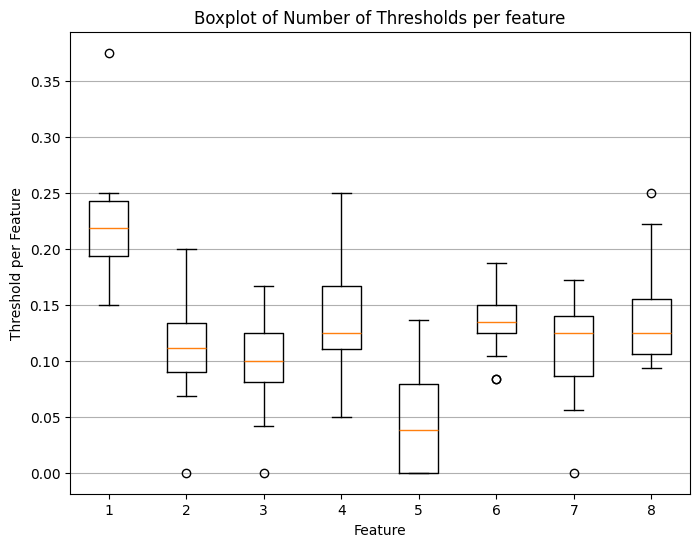

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(feature_count_total)
plt.xlabel('Feature')
plt.ylabel('Threshold per Feature')
plt.title('Boxplot of relative amount of Thresholds per feature')
plt.grid(axis='y')
plt.show()

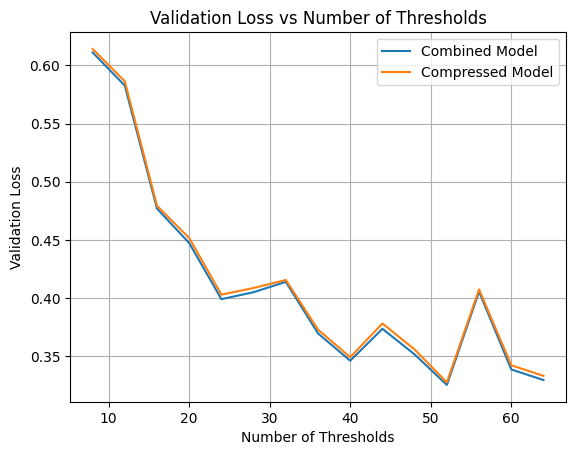

In [233]:
plt.figure()
plt.plot(range(8,max_number_thresholds+1,step), val_losses, label='Combined Model')
plt.plot(range(8,max_number_thresholds+1,step), val_loss_compressed, label='Compressed Model')
plt.xlabel('Number of Thresholds')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Number of Thresholds')
plt.legend()
plt.grid()
plt.show()

## Run 10 trains with naive and with trained amount of thresholds

In [304]:
num_thresholds = 16 
n_epochs = 25
a_init = torch.randn(num_thresholds)
a_index = torch.arange(num_thresholds)
first_index, second_index = create_indices(num_features, num_thresholds)
feature_selection_layer = FeatureSelectionLayer(first_index, second_index)
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = num_thresholds,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model_new = CombinedModelNew(feature_selection_layer, compressed_model, linear_model)
optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.003)
criterion = nn.MSELoss()
train_combined_model_new(combined_model_new, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
feature_index_after = combined_model_new.feature_selection_layer.get_features()
for f in range(num_features):
    feature_count[f] = torch.sum(feature_index_after == f)

In [305]:
feature_count= feature_count.to(int)
a_index = torch.repeat_interleave(torch.arange(num_features),feature_count.to(int))
quantile_tensor = torch.cat([torch.tensor([(f+1)/(count+1) for f in range(count)]) for count in feature_count])
a_init = torch.stack([torch.quantile(X_train_tensor[:,a_index[f]], quantile_tensor[f]) for f in range(num_thresholds)])

In [306]:
compressed_model = CompressedModel(a_init, a_index)
linear_model = MLP_small(in_features = num_thresholds,
                        out_features = 1,
                        hidden_features = 64,
                        num_layers = 2)
combined_model = CombinedModel(compressed_model, linear_model)
combined_model.to(device);

In [307]:
val_losses = []
val_losses_compressed = []
for f in tqdm(range(10)):
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model = CombinedModel(compressed_model, linear_model)
    combined_model.to(device);
    ## Train combined model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
    n_epochs = 20
    train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    val_loss_current = eval_val(combined_model, test_loader, device = device)
    val_losses.append(val_loss_current)
    val_loss_current = eval_val(combined_model, test_loader, eval=True, device=device)
    val_losses_compressed.append(val_loss_current)

100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


In [308]:
val_losses_naiv = []
val_losses_compressed_naiv = []
a_init, a_index = initialize_a(num_features=8, num_thresholds=num_thresholds//num_features, X=X_train_tensor)
for f in tqdm(range(10)):
    compressed_model = CompressedModel(a_init, a_index)
    linear_model = MLP_small(in_features = num_thresholds,
                            out_features = 1,
                            hidden_features = 64,
                            num_layers = 2)
    combined_model = CombinedModel(compressed_model, linear_model)
    combined_model.to(device);
    ## Train combined model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.003)
    n_epochs = 20
    train_combined(combined_model, train_loader, test_loader, optimizer, criterion, n_epochs, device = device, print_result=False)
    val_loss_current = eval_val(combined_model, test_loader, device = device)
    val_losses_naiv.append(val_loss_current)
    val_loss_current = eval_val(combined_model, test_loader, eval=True, device=device)
    val_losses_compressed_naiv.append(val_loss_current)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:13<00:00,  7.32s/it]


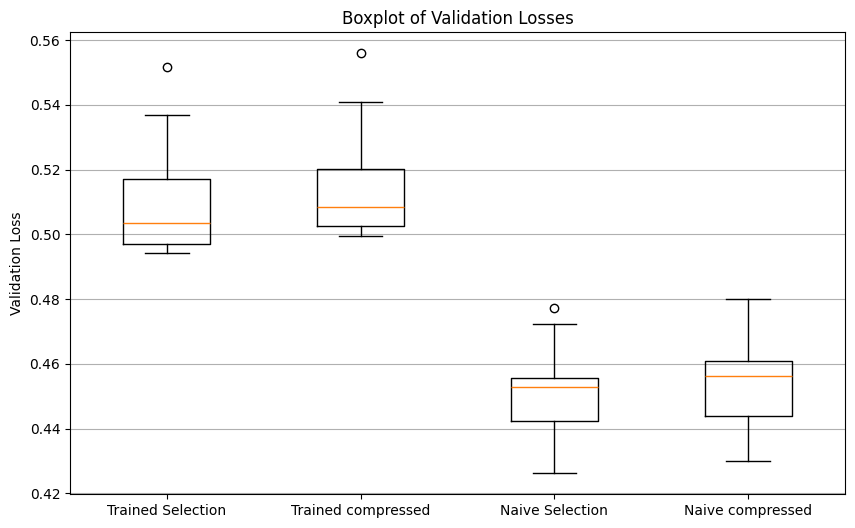

In [309]:
plt.figure(figsize=(10,6))
plt.boxplot([val_losses, val_losses_compressed, val_losses_naiv, val_losses_compressed_naiv], tick_labels=['Trained Selection', 'Trained compressed', 'Naive Selection', 'Naive compressed'])
plt.ylabel('Validation Loss')
plt.title('Boxplot of Validation Losses')
plt.grid(axis='y')
plt.show()


## Include extra loss (does not work)

This dows not work at the moment. Problem is that it produces nan values after a few training steps. 

In [39]:
class extra_loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, hidden_state, output, target):
        mse = torch.mean((output - target)**2)
        compress_loss = torch.mean(torch.sqrt(hidden_state * (1- hidden_state)))
        return mse + 0*compress_loss

In [41]:
compressed_model_new = CompressedModel(a_init, a_index)
linear_model_new = MLP_small(in_features = 64,
                        out_features = 1,
                        hidden_features = 10,
                        num_layers = 3)
combined_model_new = CombinedModel(compressed_model_new, linear_model_new)
combined_model_new.to(device);

In [42]:
loss_fn = extra_loss()
x,y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)
hidden_state, output  = combined_model_new(x)
loss_fn(hidden_state, output, y)

tensor(6.7879, device='cuda:0', grad_fn=<AddBackward0>)

In [43]:
mse = torch.mean((output - y)**2)
compress_loss = torch.mean(torch.sqrt(hidden_state * (1- hidden_state)))
alt = torch.mean(torch.abs(hidden_state - torch.round(hidden_state)))
mse, compress_loss, alt 

(tensor(6.7879, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4561, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3559, device='cuda:0', grad_fn=<MeanBackward0>))

In [44]:
## Train comparison model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combined_model_new.parameters(), lr=0.0001)
n_epochs = 100
device= 'cuda'
combined_model.to(device);

for epoch in range(n_epochs):
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        hidden_state, output = combined_model_new(x)
        loss = loss_fn(hidden_state, output, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # combined_model.compressed_model.tau = combined_model.compressed_model.tau* 0.95    
    if epoch % (n_epochs//10) == 0:
        print(f'{epoch}: {np.mean(losses)}')

0: nan
10: nan
20: nan
30: nan
40: nan
50: nan
60: nan
70: nan
80: nan
90: nan
